## Install CM font

## Show the number of flow records in the dataset and their distribution across `protocol` and `application_name`

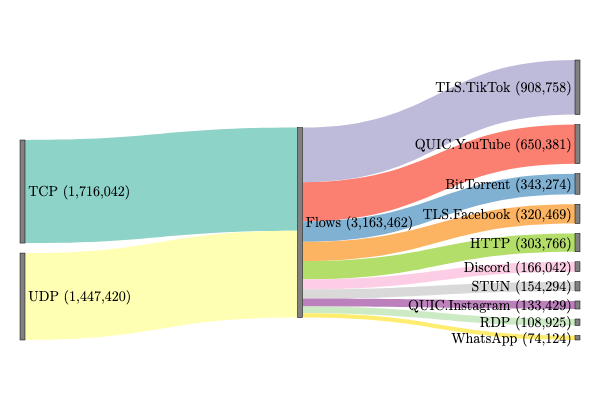

In [1]:
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
from IPython.display import Image, display


def read_and_preprocess_data(file_path: str):
    """Reads and preprocesses the data file."""
    df = pd.read_parquet(file_path)
    df['protocol'] = df['protocol'].replace({6: 'TCP', 17: 'UDP'})
    return df

def create_sankey_figure(df, color_palette):
    """Creates a Sankey diagram figure."""
    total_rows = len(df)
    protocol_dist = df['protocol'].value_counts()
    
    nodes = [dict(label=f'Flows ({total_rows:,})')]
    links = []

    for i, (protocol, count) in enumerate(protocol_dist.items()):
        nodes.append(dict(label=f'{protocol} ({count:,})'))
        links.append(dict(source=i+1, target=0, value=count, color=color_palette[i%len(color_palette)]))
    
    for i, (app, count) in enumerate(df['application_name'].value_counts().items()):
        nodes.append(dict(label=f'{app} ({count:,})'))
        links.append(dict(source=0, target=i+len(protocol_dist)+1, value=count, color=color_palette[(i+len(protocol_dist))%len(color_palette)]))
    
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=10, thickness=5, line=dict(color='black', width=0.5),
            label=[node['label'] for node in nodes],
            color='gray'),
        link=dict(
            source=[link['source'] for link in links],
            target=[link['target'] for link in links],
            value=[link['value'] for link in links],
            color=[link['color'] for link in links])
    )])
    
    fig.update_layout(
        font=dict(family='CMU Serif', size=14, color='black'),
        autosize=True, width=600, height=400,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=60, b=60)
    )

    return fig

def display_sankey_figure(fig):
    img_bytes = pio.to_image(fig, format='png')
    display(Image(img_bytes))

def save_sankey_figure(fig, output_file, scale_factor=5):
    """Saves the Sankey diagram figure as an image file."""
    pio.write_image(fig, output_file, scale=scale_factor)

if __name__ == "__main__":
    # Constants
    DATA_FILE = 'datasets/dataset.parquet'
    OUTPUT_IMAGE_FILE = 'datasets/app-distrib-sankey-vA-before.png'
    COLOR_PALETTE = px.colors.qualitative.Set3
    
    # Read and preprocess data
    df = read_and_preprocess_data(DATA_FILE)

    # Create the Sankey diagram figure
    fig = create_sankey_figure(df, COLOR_PALETTE)

    # Display the Sankey diagram as a static image
    display_sankey_figure(fig)

    # Save the Sankey diagram as a PNG file
    save_sankey_figure(fig, OUTPUT_IMAGE_FILE)

## Determine the samples to be removed per each application type to get 60 chunks without residuals

In [2]:
import pandas as pd

# Read the Parquet file into a DataFrame
df = pd.read_parquet('datasets/dataset.parquet')

# Group the samples by the 'application_name' column
grouped = df.groupby('application_name')

# Calculate the residual counts for each application_name
residual_counts_dict = {}

for app_name, group_data in grouped:
    app_total_samples = len(group_data)
    target_samples_per_chunk = app_total_samples // 60
    residual_counts = app_total_samples % target_samples_per_chunk
    residual_counts_dict[app_name] = residual_counts


# Print each key-value pair on a new line
# print(residual_counts_dict)
for app_name, residual_count in residual_counts_dict.items():
    print(f"{app_name}: {residual_count}")

BitTorrent: 14
Discord: 22
HTTP: 46
QUIC.Instagram: 49
QUIC.YouTube: 41
RDP: 25
STUN: 34
TLS.Facebook: 9
TLS.TikTok: 58
WhatsApp: 24


## Remove residuals

In [3]:
import pandas as pd

def remove_samples_from_dataset(file_path, app_types_to_remove, output_file_path):
    # Load the dataset
    df = pd.read_parquet(file_path)

    # Initialize an empty DataFrame to store the filtered data
    filtered_df = pd.DataFrame()

    # Group the dataset by application_name
    grouped = df.groupby('application_name')

    # Iterate over each group and remove the specified number of samples
    for app_type, group in grouped:
        if app_type in app_types_to_remove:
            count = app_types_to_remove[app_type]
            # Keep all but the specified number of samples for this app type
            remaining = group.iloc[count:]
            filtered_df = pd.concat([filtered_df, remaining])
        else:
            # If the app type is not in the removal list, keep all its samples
            filtered_df = pd.concat([filtered_df, group])

    # Save the modified DataFrame to a new file
    filtered_df.to_parquet(output_file_path, index=False, compression='gzip')

# Dictionary of app types to remove with their respective counts
app_types_to_remove = residual_counts_dict

input_file_path = 'datasets/dataset.parquet'
output_file_path = 'datasets/dataset_filtered.parquet'

remove_samples_from_dataset(input_file_path, app_types_to_remove, output_file_path)

## Plot the distribution of flows across protocols and application types via Sankey

### Version A

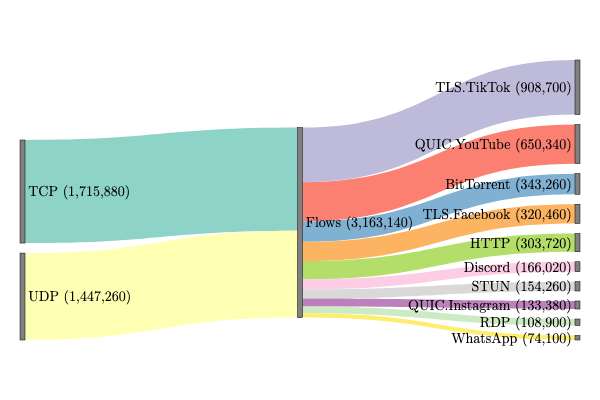

In [4]:
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
from IPython.display import Image, display


def read_and_preprocess_data(file_path: str):
    """Reads and preprocesses the data file."""
    df = pd.read_parquet(file_path)
    df['protocol'] = df['protocol'].replace({6: 'TCP', 17: 'UDP'})
    return df

def create_sankey_figure(df, color_palette):
    """Creates a Sankey diagram figure."""
    total_rows = len(df)
    protocol_dist = df['protocol'].value_counts()
    
    nodes = [dict(label=f'Flows ({total_rows:,})')]
    links = []

    for i, (protocol, count) in enumerate(protocol_dist.items()):
        nodes.append(dict(label=f'{protocol} ({count:,})'))
        links.append(dict(source=i+1, target=0, value=count, color=color_palette[i%len(color_palette)]))
    
    for i, (app, count) in enumerate(df['application_name'].value_counts().items()):
        nodes.append(dict(label=f'{app} ({count:,})'))
        links.append(dict(source=0, target=i+len(protocol_dist)+1, value=count, color=color_palette[(i+len(protocol_dist))%len(color_palette)]))
    
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=10, thickness=5, line=dict(color='black', width=0.5),
            label=[node['label'] for node in nodes],
            color='gray'),
        link=dict(
            source=[link['source'] for link in links],
            target=[link['target'] for link in links],
            value=[link['value'] for link in links],
            color=[link['color'] for link in links])
    )])
    
    fig.update_layout(
        font=dict(family='CMU Serif', size=14, color='black'),
        autosize=True, width=600, height=400,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=60, b=60)
    )

    return fig

def display_sankey_figure(fig):
    img_bytes = pio.to_image(fig, format='png')
    display(Image(img_bytes))

def save_sankey_figure(fig, output_file, scale_factor=5):
    """Saves the Sankey diagram figure as an image file."""
    pio.write_image(fig, output_file, scale=scale_factor)

if __name__ == "__main__":
    # Constants
    DATA_FILE = 'datasets/dataset_filtered.parquet'
    OUTPUT_IMAGE_FILE = 'datasets/app-distrib-sankey-vA-after.png'
    COLOR_PALETTE = px.colors.qualitative.Set3
    
    # Read and preprocess data
    df = read_and_preprocess_data(DATA_FILE)

    # Create the Sankey diagram figure
    fig = create_sankey_figure(df, COLOR_PALETTE)

    # Display the Sankey diagram as a static image
    display_sankey_figure(fig)

    # Save the Sankey diagram as a PNG file
    save_sankey_figure(fig, OUTPUT_IMAGE_FILE)

### Version B

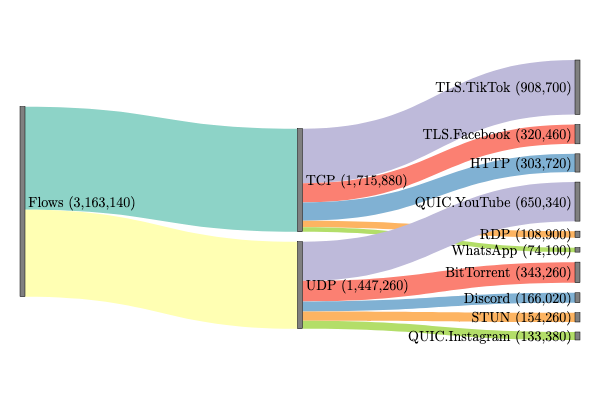

In [5]:
import os
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
from IPython.display import Image, display


def read_and_preprocess_data(file_path: str):
    """Reads and preprocesses the data file."""
    df = pd.read_parquet(file_path)
    df['protocol'] = df['protocol'].replace({6: 'TCP', 17: 'UDP'})
    return df

def create_sankey_figure(df, color_palette):
    """Creates a Sankey diagram figure."""
    total_rows = len(df)
    protocol_dist = df['protocol'].value_counts()

    # Starting node for the total number of flows
    nodes = [dict(label=f'Flows ({total_rows:,})')]
    links = []

    # Nodes and links for protocols (UDP, TCP) from the total flows
    for i, (protocol, count) in enumerate(protocol_dist.items()):
        nodes.append(dict(label=f'{protocol} ({count:,})'))
        links.append(dict(source=0, target=i+1, value=count, color=color_palette[i%len(color_palette)]))

    # Nodes and links for application names from each protocol
    for protocol, count in protocol_dist.items():
        protocol_index = nodes.index(dict(label=f'{protocol} ({count:,})'))  # Find the index of the protocol node
        for i, (app, app_count) in enumerate(df[df['protocol'] == protocol]['application_name'].value_counts().items()):
            # Check if application node already exists, if not, create one
            app_label = f'{app} ({app_count:,})'
            if app_label not in [node['label'] for node in nodes]:
                nodes.append(dict(label=app_label))
            app_index = nodes.index(dict(label=app_label))
            links.append(dict(source=protocol_index, target=app_index, value=app_count, color=color_palette[(i+len(protocol_dist))%len(color_palette)]))

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=10, thickness=5, line=dict(color='black', width=0.5),
            label=[node['label'] for node in nodes],
            color='gray'),
        link=dict(
            source=[link['source'] for link in links],
            target=[link['target'] for link in links],
            value=[link['value'] for link in links],
            color=[link['color'] for link in links])
    )])

    fig.update_layout(
        font=dict(family='CMU Serif', size=14, color='black'),
        autosize=True, width=600, height=400,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        margin=dict(l=20, r=20, t=60, b=60)
    )

    return fig

def display_sankey_figure(fig):
    img_bytes = pio.to_image(fig, format='png')
    display(Image(img_bytes))

def save_sankey_figure(fig, output_file, scale_factor=5):
    """Saves the Sankey diagram figure as an image file."""
    pio.write_image(fig, output_file, scale=scale_factor)

if __name__ == "__main__":
    # Constants
    DATA_FILE = 'datasets/dataset_filtered.parquet'
    OUTPUT_IMAGE_FILE = 'datasets/app-distrib-sankey-vB-after.png'
    COLOR_PALETTE = px.colors.qualitative.Set3
    
    # Read and preprocess data
    df = read_and_preprocess_data(DATA_FILE)

    # Create the Sankey diagram figure
    fig = create_sankey_figure(df, COLOR_PALETTE)

    # Display the Sankey diagram as a static image
    display_sankey_figure(fig)

    # Save the Sankey diagram as a PNG file
    save_sankey_figure(fig, OUTPUT_IMAGE_FILE)

## Encode the application labels

In [6]:
import os
import pandas as pd
import logging
from pprint import pformat

def setup_logging(log_filename):
    """
    Setup the logging configuration.
    """
    # Clear the existing log file, if it exists
    with open(log_filename, 'w'):
        pass

    # Set up logging to file and console
    logging.basicConfig(level=logging.INFO,
                        force=True,
                        format='%(message)s',
                        handlers=[logging.FileHandler(log_filename), logging.StreamHandler()])

def label_mapping(input_file_name: str, output_file_name: str):
    """
    Create and apply label encoding to the 'application_name' column of the input CSV.
    
    Parameters:
    - input_file_name (str): Path to the input CSV file.
    - output_file_name (str): Path for the output CSV file with label encoding applied.
    """
    # Read CSV file
    df = pd.read_parquet(input_file_name)
    
    # Create a dictionary that maps the application names to an encoding based on their frequency
    app_counts = df['application_name'].value_counts()
    encoding = {app: i for i, app in enumerate(app_counts.index)}

    # Create the reverse mapping
    reverse_encoding = {v: k for k, v in encoding.items()}

    # Log the encoding and reverse_encoding dictionaries
    logging.info(f"Label mapping:\n{pformat(encoding)}")
    logging.info(f"\nReverse label mapping:\n{pformat(reverse_encoding)}")

    # Replace the application names with the encoding
    df.loc[:, 'application_name'] = df['application_name'].map(encoding)
    df['application_name'] = pd.to_numeric(df['application_name'], downcast='integer')

    df.to_parquet(output_file_name, index=False, compression='gzip')

if __name__ == "__main__":
    # Constants
    LOG_FILENAME = "datasets/label-encoding.log"
    INPUT_FILE_NAME = 'datasets/dataset_filtered.parquet'
    OUTPUT_FILE_NAME = 'datasets/dataset_label_encoded.parquet'

    # Setup logging
    setup_logging(LOG_FILENAME)

    # Apply label mapping and save to file
    label_mapping(INPUT_FILE_NAME, OUTPUT_FILE_NAME)

Label mapping:
{'BitTorrent': 2,
 'Discord': 5,
 'HTTP': 4,
 'QUIC.Instagram': 7,
 'QUIC.YouTube': 1,
 'RDP': 8,
 'STUN': 6,
 'TLS.Facebook': 3,
 'TLS.TikTok': 0,
 'WhatsApp': 9}

Reverse label mapping:
{0: 'TLS.TikTok',
 1: 'QUIC.YouTube',
 2: 'BitTorrent',
 3: 'TLS.Facebook',
 4: 'HTTP',
 5: 'Discord',
 6: 'STUN',
 7: 'QUIC.Instagram',
 8: 'RDP',
 9: 'WhatsApp'}


## Show the columns in the dataset

In [7]:
import pyarrow.parquet as pq

# Specify the path to the Parquet file
parquet_file_path = 'datasets/dataset_label_encoded.parquet'

# Read the Parquet file into a ParquetFile object
parquet_file = pq.ParquetFile(parquet_file_path)

# Get the schema of the Parquet file
schema = parquet_file.schema

# Get the column names from the schema
column_names = schema.names

print("Column names in the Parquet file:")
for column_name in column_names:
    print(column_name)

Column names in the Parquet file:
src_ip
src_port
dst_ip
dst_port
protocol
bidirectional_first_seen_ms
bidirectional_last_seen_ms
bidirectional_duration_ms
bidirectional_packets
bidirectional_bytes
src2dst_first_seen_ms
src2dst_last_seen_ms
src2dst_duration_ms
src2dst_packets
src2dst_bytes
dst2src_first_seen_ms
dst2src_last_seen_ms
dst2src_duration_ms
dst2src_packets
dst2src_bytes
bidirectional_min_ps
bidirectional_mean_ps
bidirectional_stddev_ps
bidirectional_max_ps
src2dst_min_ps
src2dst_mean_ps
src2dst_stddev_ps
src2dst_max_ps
dst2src_min_ps
dst2src_mean_ps
dst2src_stddev_ps
dst2src_max_ps
bidirectional_min_piat_ms
bidirectional_mean_piat_ms
bidirectional_stddev_piat_ms
bidirectional_max_piat_ms
src2dst_min_piat_ms
src2dst_mean_piat_ms
src2dst_stddev_piat_ms
src2dst_max_piat_ms
dst2src_min_piat_ms
dst2src_mean_piat_ms
dst2src_stddev_piat_ms
dst2src_max_piat_ms
bidirectional_syn_packets
bidirectional_cwr_packets
bidirectional_ece_packets
bidirectional_urg_packets
bidirectional_ack_pa

## Remove selected columns

In [8]:
import pandas as pd

# Read the Parquet file into a DataFrame
df = pd.read_parquet('datasets/dataset_label_encoded.parquet')

# Drop the specified columns
columns_to_drop = ['src_ip', 'src_port', 'dst_ip', 'dst_port', 'application_category_name', 'client_fingerprint', 'server_fingerprint']
df = df.drop(columns=columns_to_drop)

# Write the modified DataFrame to a new Parquet file
output_parquet_file = 'datasets/dataset_label_encoded.parquet'
df.to_parquet(output_parquet_file, index=False, compression='gzip')

print(f"Columns {', '.join(columns_to_drop)} dropped.\nData saved to '{output_parquet_file}'")

Columns src_ip, src_port, dst_ip, dst_port, application_category_name, client_fingerprint, server_fingerprint dropped.
Data saved to 'datasets/dataset_label_encoded.parquet'


## Perform feature selection

In [9]:
import os
import pandas as pd
import logging
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

def setup_logging(log_filename):
    with open(log_filename, 'w'):
        pass
    logging.basicConfig(level=logging.INFO,
                        force=True,
                        format='%(message)s',
                        handlers=[logging.FileHandler(log_filename), logging.StreamHandler()])

def select_features(input_file_name: str, output_file_name: str, feature_importance_threshold: float, random_state: int):
    df = pd.read_parquet(input_file_name)
    X = df.loc[:, df.columns != 'application_name']
    y = df['application_name']
    
    logging.info(f"Training ExtraTreesClassifier...")
    clf = ExtraTreesClassifier(n_estimators=1000, random_state=random_state, n_jobs=-1)
    clf.fit(X, y)
    logging.info(f"ExtraTreesClassifier trained\n")
    
    for feature in zip(X.columns, clf.feature_importances_):
        logging.info(f'Feature: {feature[0]}, Importance: {feature[1]}')
    
    logging.info(f"\nSelecting features...")
    sfm = SelectFromModel(clf, threshold=feature_importance_threshold, prefit=True)
    
    feature_selected = []
    for feature_list_index in sfm.get_support(indices=True):
        logging.info(f'Selected feature: {X.columns[feature_list_index]}')
        feature_selected.append(X.columns[feature_list_index])
    df_selected = df.loc[:, feature_selected].copy()
    df_selected.loc[:, 'application_name'] = df['application_name']
    
    logging.info(f"\nFeature selection done, {len(feature_selected)} features selected")
    df_selected.to_parquet(output_file_name, index=False, compression='gzip')


if __name__ == "__main__":
    # Constants
    LOG_FILENAME = "datasets/feature-selection.log"
    INPUT_FILE_NAME = 'datasets/dataset_label_encoded.parquet'
    OUTPUT_FILE_NAME = "datasets/dataset_cl.parquet"
    FEATURE_IMPORTANCE_THRESHOLD = 0.02
    RANDOM_STATE = 0

    # Setup logging
    setup_logging(LOG_FILENAME)
    
    # Execute function with specified parameters
    select_features(INPUT_FILE_NAME, OUTPUT_FILE_NAME, FEATURE_IMPORTANCE_THRESHOLD, RANDOM_STATE)

Training ExtraTreesClassifier...
ExtraTreesClassifier trained

Feature: protocol, Importance: 0.1357531821547258
Feature: bidirectional_first_seen_ms, Importance: 0.0012551594672750516
Feature: bidirectional_last_seen_ms, Importance: 0.0013142640561081356
Feature: bidirectional_duration_ms, Importance: 0.011010846164795612
Feature: bidirectional_packets, Importance: 0.0038290866455376474
Feature: bidirectional_bytes, Importance: 0.003701678422914273
Feature: src2dst_first_seen_ms, Importance: 0.0013415659127396342
Feature: src2dst_last_seen_ms, Importance: 0.001297954831050001
Feature: src2dst_duration_ms, Importance: 0.01194035803814711
Feature: src2dst_packets, Importance: 0.003631693346933304
Feature: src2dst_bytes, Importance: 0.003803599289735816
Feature: dst2src_first_seen_ms, Importance: 0.002638403425850565
Feature: dst2src_last_seen_ms, Importance: 0.002717545514436445
Feature: dst2src_duration_ms, Importance: 0.011299506947723106
Feature: dst2src_packets, Importance: 0.004030

## Chunk the dataset

In our study, we examine the following conditions for the input dataset chunks:

|                                                   | IID   | non-IID-A | non-IID-B | non-IID-C |
|---------------------------------------------------|-------|-----------|-----------|-----------|
| Each chunk has identical sample size              | 1     | 0         | 0         | 0         |
| Each chunk has identical application distribution | 1     | 1         | 0         | 0         |
| Each chunk has identical application count        | 1     | 1         | 1         | 0         |

We focus solely on the label (application type) and not on the distribution of other features, we are simplifying the experiment to specifically assess how label distribution impacts federated learning. 

We plan to extend our study in the future to understand how other feature distributions impact performance.

### Prepare IID chunks

In the IID scenario, every data chunk has an identical sample size, ensuring that each participant receives an equal number of samples. This mirrors the assumption that data is evenly distributed among participants.

In [10]:
import os
import pandas as pd
import logging
from sklearn.utils import shuffle

def setup_logging(log_filename):
    os.makedirs(os.path.dirname(log_filename), exist_ok=True)
    
    with open(log_filename, 'w'):
        pass
    logging.basicConfig(level=logging.INFO,
                        format='%(message)s',
                        force=True,
                        handlers=[logging.FileHandler(log_filename),
                                  logging.StreamHandler()])

def save_and_log_chunk(chunk, i, output_dir):
    logging.info(f"Distribution for Chunk {i}:\n{chunk['application_name'].value_counts().to_string(header=False)}")
    logging.info(f"Percentage Distribution for Chunk {i}:\n{(chunk['application_name'].value_counts(normalize=True)* 100).round(2).to_string(header=False)}")
    logging.info(f"Total samples in Chunk {i}: {len(chunk)}")
    logging.info(f"-----------------")
    chunk.to_csv(os.path.join(output_dir, f'iid_chunk_{i}.csv'), index=False)

def iid_chunker(input_csv, num_chunks, output_dir, random_state, shuffle_data=True, include_residual=False):
    setup_logging(LOG_FILENAME)
    try:
        df = pd.read_parquet(input_csv)
        if shuffle_data:
            df = shuffle(df, random_state=random_state)
        os.makedirs(output_dir, exist_ok=True)
        num_chunks = int(num_chunks)

        chunks = [pd.DataFrame(columns=df.columns) for _ in range(num_chunks)]

        for _, app_df in df.groupby('application_name'):
            samples_per_chunk = len(app_df) // num_chunks
            residue = len(app_df) % num_chunks if include_residual else 0
            
            for i in range(num_chunks):
                chunk_start = i * samples_per_chunk
                chunk_end = (i + 1) * samples_per_chunk + (residue if i == num_chunks-1 else 0) # Add residue to the last chunk
                chunk = app_df[chunk_start:chunk_end]
                chunks[i] = pd.concat([chunks[i], chunk])

        for i, chunk in enumerate(chunks, start=1):
            save_and_log_chunk(chunk, i, output_dir)

    except Exception as e:
        logging.error(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    # Constants
    LOG_FILENAME = "datasets/iid/IID-info.log"
    INPUT_CSV = 'datasets/dataset_cl.parquet'
    NUM_CHUNKS = 60
    OUTPUT_DIR = "datasets/iid"
    RANDOM_STATE = 42
    SHUFFLE_DATA = False
    INCLUDE_RESIDUAL = False 
    
    iid_chunker(INPUT_CSV, NUM_CHUNKS, OUTPUT_DIR, RANDOM_STATE, SHUFFLE_DATA, INCLUDE_RESIDUAL)

Distribution for Chunk 1:
0    15145
1    10839
2     5721
3     5341
4     5062
5     2767
6     2571
7     2223
8     1815
9     1235
Percentage Distribution for Chunk 1:
0    28.73
1    20.56
2    10.85
3    10.13
4     9.60
5     5.25
6     4.88
7     4.22
8     3.44
9     2.34
Total samples in Chunk 1: 52719
-----------------
Distribution for Chunk 2:
0    15145
1    10839
2     5721
3     5341
4     5062
5     2767
6     2571
7     2223
8     1815
9     1235
Percentage Distribution for Chunk 2:
0    28.73
1    20.56
2    10.85
3    10.13
4     9.60
5     5.25
6     4.88
7     4.22
8     3.44
9     2.34
Total samples in Chunk 2: 52719
-----------------
Distribution for Chunk 3:
0    15145
1    10839
2     5721
3     5341
4     5062
5     2767
6     2571
7     2223
8     1815
9     1235
Percentage Distribution for Chunk 3:
0    28.73
1    20.56
2    10.85
3    10.13
4     9.60
5     5.25
6     4.88
7     4.22
8     3.44
9     2.34
Total samples in Chunk 3: 52719
-----------------
D

#### Plot application distribution in IID chunks

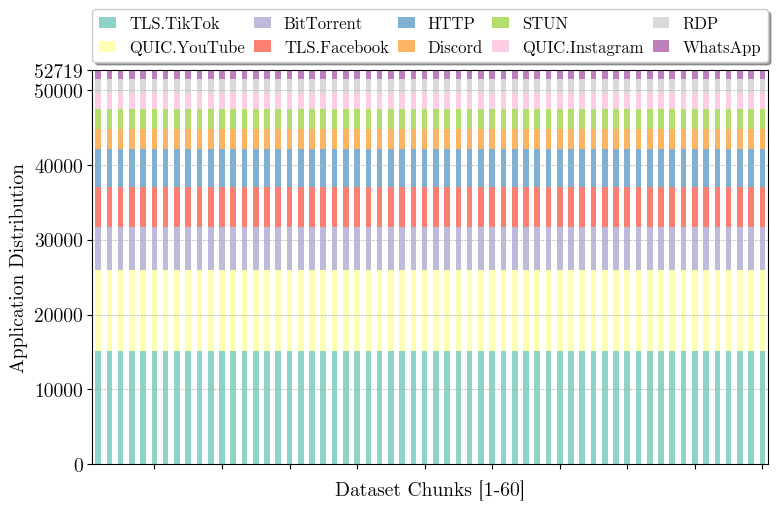

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted

# Set the font family and size
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = 14

# Set the Seaborn color palette
sns.set_palette('Set3')

# Label mapping
mapping = {0: 'TLS.TikTok',
 1: 'QUIC.YouTube',
 2: 'BitTorrent',
 3: 'TLS.Facebook',
 4: 'HTTP',
 5: 'Discord',
 6: 'STUN',
 7: 'QUIC.Instagram',
 8: 'RDP',
 9: 'WhatsApp'}

# Specify the subfolder
subfolder = 'datasets/iid'

# Get all CSV files in the subfolder
csv_files = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.endswith('.csv')]

# Sort the files alphabetically
csv_files = natsorted(csv_files)

# Initialize an empty DataFrame to hold all the value counts
all_counts = pd.DataFrame()

# Initialize a variable to hold the maximum value count
max_value_count = 0

for idx, file in enumerate(csv_files):
    # Load the CSV data
    df = pd.read_csv(file, low_memory=False)

    # Check if 'application_name' is in dataframe columns
    if 'application_name' in df.columns:
        # Replace encoded values with their respective application names
        df['application_name'].replace(mapping, inplace=True)

        # Get value counts for 'application_name'
        app_counts = df['application_name'].value_counts()

        # Update the maximum value count if necessary
        max_value_count = max(max_value_count, app_counts.sum())

        # Convert the value counts to a DataFrame and transpose it
        app_counts_df = pd.DataFrame(app_counts).T

        # Change the index to the file number
        app_counts_df.index = [idx+1]  # make index 1-based

        # Append the value counts to the all_counts DataFrame
        all_counts = pd.concat([all_counts, app_counts_df])
    else:
        print(f"'application_name' column not found in {file}")

# Create the stacked bar plot
ax = all_counts.plot(kind='bar', stacked=True, figsize=(8, 5.33))

# Set the y-axis limit slightly above the maximum value count
ax.set_ylim([0, max_value_count])

# Set the y-axis ticks excluding the extended y-axis limit
ax.set_yticks(list(filter(lambda x: x <= max_value_count, ax.get_yticks())) + [max_value_count])

# Set the legend title and place it above the plot
ax.legend(
    #title='Application Type'
           bbox_to_anchor=(0., 1.02, 1., .102)
          , loc='lower left'
          , ncol=5
          , mode="expand"
          , borderaxespad=0.
          , fancybox=True
          , shadow=True
          , prop={'size': 12}
          , handlelength=1  # Adjust this value to reduce or increase the bar width
          )

# Set the x and y axis titles
ax.set_xlabel('Dataset Chunks [1-60]')
ax.set_ylabel('Application Distribution')

# Remove x-axis ticks and labels
# ax.set_xticks([])
ax.set_xticks([5,11,17,23,29,35,41,47,53,59])
ax.set_xticklabels([])

# Remove the text for the zero label on the y axis
# yticks = ax.get_yticks()
# if 40000 in yticks:
#     yticklabels = [str(int(tick)) if tick != 40000 else '' for tick in yticks]
#     ax.set_yticklabels(yticklabels)

# Customize the grid lines
ax.grid(axis='y', linestyle='--', linewidth=0.5)

# Set plot layout to be compact
plt.tight_layout()

# Save the plot
plt.savefig('datasets/iid/iid_distribution.png', dpi=300)

# Optionally show the plot
plt.show()

#### Redistribute chunks between folders destined for FL clients

In [12]:
import shutil
import os

# Constants
ORIGINAL_CHUNK_DIR = "datasets/iid"
DISTRIBUTION_SUBDIRS = [
    "c1_data_chunks",
    "c2_data_chunks",
    "c3_data_chunks",
    "c4_data_chunks",
    "c5_data_chunks",
    "validation_data_chunks"
]

# Ensure distribution directories exist
for subdir_name in DISTRIBUTION_SUBDIRS:
    os.makedirs(os.path.join(ORIGINAL_CHUNK_DIR, subdir_name), exist_ok=True)

# Distribute the chunks
num_chunks = 60

# Counters for each subfolder
subfolder_counters = [0] * len(DISTRIBUTION_SUBDIRS)

for i in range(1, num_chunks + 1):
    source_file = os.path.join(ORIGINAL_CHUNK_DIR, f"iid_chunk_{i}.csv")
    
    # Determine the target directory based on the chunk index
    target_subdir_index = (i - 1) % len(DISTRIBUTION_SUBDIRS)
    target_subdir = DISTRIBUTION_SUBDIRS[target_subdir_index]
    
    # Increment the appropriate counter and construct the target file name
    subfolder_counters[target_subdir_index] += 1
    new_chunk_name = f"iid_chunk_{subfolder_counters[target_subdir_index]}.csv"
    target_file = os.path.join(ORIGINAL_CHUNK_DIR, target_subdir, new_chunk_name)
    
    # Move the chunk to the target directory
    shutil.move(source_file, target_file)

### Prepare IID shuffled chunks

In [13]:
import os
import pandas as pd
import logging
from sklearn.utils import shuffle

def setup_logging(log_filename):
    os.makedirs(os.path.dirname(log_filename), exist_ok=True)
    
    with open(log_filename, 'w'):
        pass
    logging.basicConfig(level=logging.INFO,
                        format='%(message)s',
                        force=True,
                        handlers=[logging.FileHandler(log_filename),
                                  logging.StreamHandler()])

def save_and_log_chunk(chunk, i, output_dir):
    logging.info(f"Distribution for Chunk {i}:\n{chunk['application_name'].value_counts().to_string(header=False)}")
    logging.info(f"Percentage Distribution for Chunk {i}:\n{(chunk['application_name'].value_counts(normalize=True)* 100).round(2).to_string(header=False)}")
    logging.info(f"Total samples in Chunk {i}: {len(chunk)}")
    logging.info(f"-----------------")
    chunk.to_csv(os.path.join(output_dir, f'iid_chunk_{i}.csv'), index=False)

def iid_chunker(input_csv, num_chunks, output_dir, random_state, shuffle_data=True, include_residual=False):
    setup_logging(LOG_FILENAME)
    try:
        df = pd.read_parquet(input_csv)
        if shuffle_data:
            df = shuffle(df, random_state=random_state)
        os.makedirs(output_dir, exist_ok=True)
        num_chunks = int(num_chunks)

        chunks = [pd.DataFrame(columns=df.columns) for _ in range(num_chunks)]

        for _, app_df in df.groupby('application_name'):
            samples_per_chunk = len(app_df) // num_chunks
            residue = len(app_df) % num_chunks if include_residual else 0
            
            for i in range(num_chunks):
                chunk_start = i * samples_per_chunk
                chunk_end = (i + 1) * samples_per_chunk + (residue if i == num_chunks-1 else 0) # Add residue to the last chunk
                chunk = app_df[chunk_start:chunk_end]
                chunks[i] = pd.concat([chunks[i], chunk])

        for i, chunk in enumerate(chunks, start=1):
            save_and_log_chunk(chunk, i, output_dir)

    except Exception as e:
        logging.error(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    # Constants
    LOG_FILENAME = "datasets/iid_shuffled/IID-info.log"
    INPUT_CSV = 'datasets/dataset_cl.parquet'
    NUM_CHUNKS = 60
    OUTPUT_DIR = "datasets/iid_shuffled"
    RANDOM_STATE = 42
    SHUFFLE_DATA = True
    INCLUDE_RESIDUAL = False 
    
    iid_chunker(INPUT_CSV, NUM_CHUNKS, OUTPUT_DIR, RANDOM_STATE, SHUFFLE_DATA, INCLUDE_RESIDUAL)

Distribution for Chunk 1:
0    15145
1    10839
2     5721
3     5341
4     5062
5     2767
6     2571
7     2223
8     1815
9     1235
Percentage Distribution for Chunk 1:
0    28.73
1    20.56
2    10.85
3    10.13
4     9.60
5     5.25
6     4.88
7     4.22
8     3.44
9     2.34
Total samples in Chunk 1: 52719
-----------------
Distribution for Chunk 2:
0    15145
1    10839
2     5721
3     5341
4     5062
5     2767
6     2571
7     2223
8     1815
9     1235
Percentage Distribution for Chunk 2:
0    28.73
1    20.56
2    10.85
3    10.13
4     9.60
5     5.25
6     4.88
7     4.22
8     3.44
9     2.34
Total samples in Chunk 2: 52719
-----------------
Distribution for Chunk 3:
0    15145
1    10839
2     5721
3     5341
4     5062
5     2767
6     2571
7     2223
8     1815
9     1235
Percentage Distribution for Chunk 3:
0    28.73
1    20.56
2    10.85
3    10.13
4     9.60
5     5.25
6     4.88
7     4.22
8     3.44
9     2.34
Total samples in Chunk 3: 52719
-----------------
D

#### Plot application distribution in IID schuffled chunks

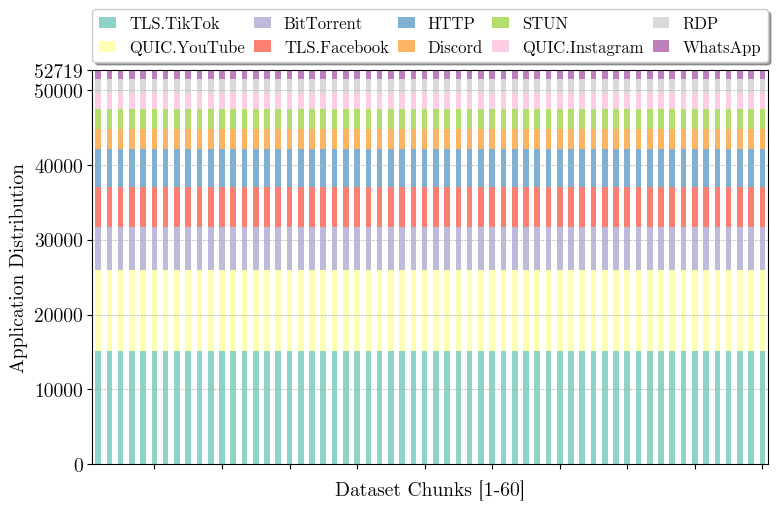

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted

# Set the font family and size
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = 14

# Set the Seaborn color palette
sns.set_palette('Set3')

# Label mapping
mapping = {0: 'TLS.TikTok',
 1: 'QUIC.YouTube',
 2: 'BitTorrent',
 3: 'TLS.Facebook',
 4: 'HTTP',
 5: 'Discord',
 6: 'STUN',
 7: 'QUIC.Instagram',
 8: 'RDP',
 9: 'WhatsApp'}

# Specify the subfolder
subfolder = 'datasets/iid_shuffled'

# Get all CSV files in the subfolder
csv_files = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.endswith('.csv')]

# Sort the files alphabetically
csv_files = natsorted(csv_files)

# Initialize an empty DataFrame to hold all the value counts
all_counts = pd.DataFrame()

# Initialize a variable to hold the maximum value count
max_value_count = 0

for idx, file in enumerate(csv_files):
    # Load the CSV data
    df = pd.read_csv(file, low_memory=False)

    # Check if 'application_name' is in dataframe columns
    if 'application_name' in df.columns:
        # Replace encoded values with their respective application names
        df['application_name'].replace(mapping, inplace=True)

        # Get value counts for 'application_name'
        app_counts = df['application_name'].value_counts()

        # Update the maximum value count if necessary
        max_value_count = max(max_value_count, app_counts.sum())

        # Convert the value counts to a DataFrame and transpose it
        app_counts_df = pd.DataFrame(app_counts).T

        # Change the index to the file number
        app_counts_df.index = [idx+1]  # make index 1-based

        # Append the value counts to the all_counts DataFrame
        all_counts = pd.concat([all_counts, app_counts_df])
    else:
        print(f"'application_name' column not found in {file}")

# Create the stacked bar plot
ax = all_counts.plot(kind='bar', stacked=True, figsize=(8, 5.33))

# Set the y-axis limit slightly above the maximum value count
ax.set_ylim([0, max_value_count])

# Set the y-axis ticks excluding the extended y-axis limit
ax.set_yticks(list(filter(lambda x: x <= max_value_count, ax.get_yticks())) + [max_value_count])

# Set the legend title and place it above the plot
ax.legend(
    #title='Application Type'
           bbox_to_anchor=(0., 1.02, 1., .102)
          , loc='lower left'
          , ncol=5
          , mode="expand"
          , borderaxespad=0.
          , fancybox=True
          , shadow=True
          , prop={'size': 12}
          , handlelength=1  # Adjust this value to reduce or increase the bar width
          )

# Set the x and y axis titles
ax.set_xlabel('Dataset Chunks [1-60]')
ax.set_ylabel('Application Distribution')

# Remove x-axis ticks and labels
# ax.set_xticks([])
ax.set_xticks([5,11,17,23,29,35,41,47,53,59])
ax.set_xticklabels([])

# Remove the text for the zero label on the y axis
# yticks = ax.get_yticks()
# if 40000 in yticks:
#     yticklabels = [str(int(tick)) if tick != 40000 else '' for tick in yticks]
#     ax.set_yticklabels(yticklabels)

# Customize the grid lines
ax.grid(axis='y', linestyle='--', linewidth=0.5)

# Set plot layout to be compact
plt.tight_layout()

# Save the plot
plt.savefig('datasets/iid_shuffled/iid_shuffled_distribution.png', dpi=300)

# Optionally show the plot
plt.show()

#### Redistribute chunks between folders destined for FL clients

In [15]:
import shutil
import os

# Constants
ORIGINAL_CHUNK_DIR = "datasets/iid_shuffled"
DISTRIBUTION_SUBDIRS = [
    "c1_data_chunks",
    "c2_data_chunks",
    "c3_data_chunks",
    "c4_data_chunks",
    "c5_data_chunks",
    "validation_data_chunks"
]

# Ensure distribution directories exist
for subdir_name in DISTRIBUTION_SUBDIRS:
    os.makedirs(os.path.join(ORIGINAL_CHUNK_DIR, subdir_name), exist_ok=True)

# Distribute the chunks
num_chunks = 60

# Counters for each subfolder
subfolder_counters = [0] * len(DISTRIBUTION_SUBDIRS)

for i in range(1, num_chunks + 1):
    source_file = os.path.join(ORIGINAL_CHUNK_DIR, f"iid_chunk_{i}.csv")
    
    # Determine the target directory based on the chunk index
    target_subdir_index = (i - 1) % len(DISTRIBUTION_SUBDIRS)
    target_subdir = DISTRIBUTION_SUBDIRS[target_subdir_index]
    
    # Increment the appropriate counter and construct the target file name
    subfolder_counters[target_subdir_index] += 1
    new_chunk_name = f"iid_shuffled_chunk_{subfolder_counters[target_subdir_index]}.csv"
    target_file = os.path.join(ORIGINAL_CHUNK_DIR, target_subdir, new_chunk_name)
    
    # Move the chunk to the target directory
    shutil.move(source_file, target_file)

### Prepare non-IID-A chunks

For the non-IID-A condition, chunks differ in sample size, reflecting a more realistic situation where some participants may have more data than others. However, the precentual distribution of application types accross all the chunks is equal.

In [16]:
import pandas as pd
import logging
from sklearn.utils import shuffle
import argparse
import numpy as np
import random
import os

def setup_logging(log_filename):
    os.makedirs(os.path.dirname(log_filename), exist_ok=True)
    
    with open(log_filename, 'w'):
        pass
    logging.basicConfig(level=logging.INFO,
                        format='%(message)s',
                        force=True,
                        handlers=[logging.FileHandler(log_filename),
                                  logging.StreamHandler()])

def chunk_dataframe(df, num_chunks):
    available_apps = df['application_name'].unique().tolist()
    
    chunks = []
    ideal_chunk_size = len(df) // num_chunks
    min_samples_per_chunk = round(ideal_chunk_size * 0.7)  # 30% less
    max_samples_per_chunk = round(ideal_chunk_size * 1.3)  # 30% more

    # Get the overall distribution of the 'application_name' in the input CSV
    app_distribution = df['application_name'].value_counts(normalize=True)

    uniform_chunks_indexes = range(6, num_chunks+1, 6) # 6th, 12th, 18th, ... chunks

    # Create uniformly distributed chunks first
    for i in uniform_chunks_indexes:
        chunk = pd.DataFrame()
        for app in available_apps:
            app_df = df[df['application_name'] == app]
            # print(f"Application: {app}, Available Samples: {len(app_df)}")
            samples_to_add = int(app_distribution[app] * ideal_chunk_size)
            samples_to_add = min(samples_to_add, len(app_df))
            # print(f"Attempting to sample {samples_to_add} from {app}")
            sample_df = app_df.sample(n=samples_to_add, replace=False, random_state=RANDOM_STATE)
            df = df.drop(sample_df.index)
            chunk = pd.concat([chunk, sample_df])
        chunks.append((i, chunk))

    total_remaining_samples = len(df)
    num_units = 50 # 60 - 10 (the uniformly distributed chunks)
#     non_iid_chunks_sizes = []
    # Initial random assignment
    non_iid_chunks_sizes = [random.randint(min_samples_per_chunk, max_samples_per_chunk) for _ in range(num_units)]

    # Calculate the difference and distribute it evenly
    difference = total_remaining_samples - sum(non_iid_chunks_sizes)
    per_chunk_difference = difference // num_units
    non_iid_chunks_sizes = [size + per_chunk_difference for size in non_iid_chunks_sizes]
    
    # Distribute any remaining difference to random chunks
    remaining_difference = difference % num_units
    for i in np.random.choice(num_units, remaining_difference, replace=False):
        non_iid_chunks_sizes[i] += 1
    
    # print(non_iid_chunks_sizes)
    # print(sum(non_iid_chunks_sizes))

    non_iid_chunk_index = 0
    for i in range(1, num_chunks + 1):
        if i in uniform_chunks_indexes:  # If it is a uniformly distributed chunk, skip
            continue

        chunk_size = non_iid_chunks_sizes[non_iid_chunk_index]
        non_iid_chunk_index += 1

        # print(f"Chunk {i}, Desired size: {chunk_size}, Available rows in df: {len(df)}")
        
        chunk = df.sample(n=chunk_size, replace=False)
        df = df.drop(chunk.index)
        chunks.append((i, chunk))
    
    # Sort chunks based on their index
    chunks.sort(key=lambda x: x[0])

    # Return only chunk data
    chunks = [chunk for index, chunk in chunks]

    return chunks

def save_and_log_chunk(chunk, i, output_dir):
    logging.info(f"Distribution for Chunk {i}:\n{chunk['application_name'].value_counts().to_string(header=False)}")
    logging.info(f"Percentage Distribution for Chunk {i}:\n{(chunk['application_name'].value_counts(normalize=True)* 100).round(2).to_string(header=False)}")
    logging.info(f"Total samples in Chunk {i}: {len(chunk)}")
    logging.info(f"-----------------")    
    chunk.to_csv(os.path.join(output_dir, f'non_iid_chunk_{i}.csv'), index=False)


def non_iid_chunker(input_csv, num_chunks, shuffle_data, output_dir):
    setup_logging(LOG_FILENAME)
    
    try:
        df = pd.read_parquet(input_csv)
        num_chunks = int(num_chunks)
        os.makedirs(output_dir, exist_ok=True)
        
        if shuffle_data:
            df = shuffle(df, random_state=RANDOM_STATE)
        
        chunks = chunk_dataframe(df, num_chunks)

        # Print the distribution for each chunk and save the chunks
        for i, chunk in enumerate(chunks, start=1):
            save_and_log_chunk(chunk, i, output_dir)
    
    except Exception as e:
        logging.error(f"An error occurred: {str(e)}")
        

if __name__ == "__main__":    
    # Constants
    LOG_FILENAME = "datasets/non_iid_A/non-IID-info.log"
    INPUT_CSV = 'datasets/dataset_cl.parquet'
    NUM_CHUNKS = 60
    SHUFFLE_DATA = False
    OUTPUT_DIR = "datasets/non_iid_A"
    RANDOM_STATE = 42

    np.random.seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)

    non_iid_chunker(INPUT_CSV, NUM_CHUNKS, SHUFFLE_DATA, OUTPUT_DIR)

Distribution for Chunk 1:
0    17325
1    12090
2     6384
3     6009
4     5814
5     3140
6     2880
7     2462
8     2069
9     1407
Percentage Distribution for Chunk 1:
0    29.08
1    20.29
2    10.72
3    10.09
4     9.76
5     5.27
6     4.83
7     4.13
8     3.47
9     2.36
Total samples in Chunk 1: 59580
-----------------
Distribution for Chunk 2:
0    12131
1     8651
2     4576
3     4354
4     4090
5     2213
6     2038
7     1754
8     1471
9      998
Percentage Distribution for Chunk 2:
0    28.69
1    20.46
2    10.82
3    10.30
4     9.67
5     5.23
6     4.82
7     4.15
8     3.48
9     2.36
Total samples in Chunk 2: 42276
-----------------
Distribution for Chunk 3:
0    11405
1     7927
2     4349
3     3960
4     3848
5     2116
6     1900
7     1670
8     1335
9      937
Percentage Distribution for Chunk 3:
0    28.91
1    20.10
2    11.02
3    10.04
4     9.75
5     5.36
6     4.82
7     4.23
8     3.38
9     2.38
Total samples in Chunk 3: 39447
-----------------
D

#### Plot application distribution in non-IID-A chunks

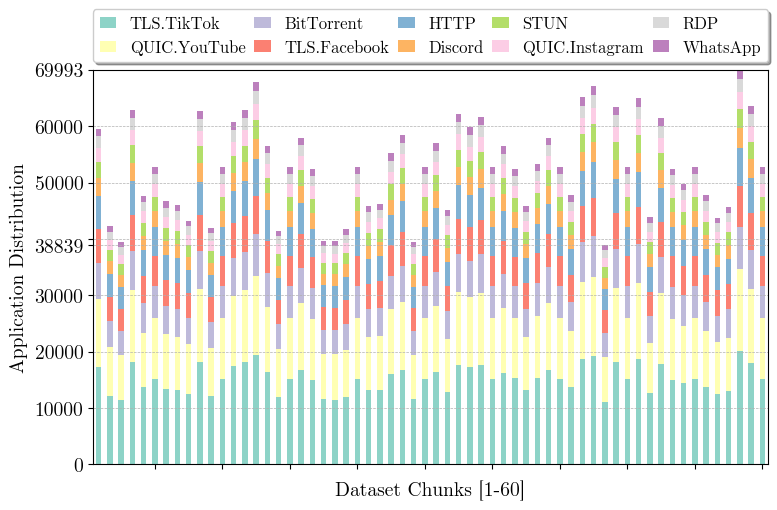

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted

# Set the font family and size
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = 14

# Set the Seaborn color palette
sns.set_palette('Set3')

# Label mapping
mapping = {0: 'TLS.TikTok',
 1: 'QUIC.YouTube',
 2: 'BitTorrent',
 3: 'TLS.Facebook',
 4: 'HTTP',
 5: 'Discord',
 6: 'STUN',
 7: 'QUIC.Instagram',
 8: 'RDP',
 9: 'WhatsApp'}

# Specify the subfolder
subfolder = 'datasets/non_iid_A'

# Get all CSV files in the subfolder
csv_files = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.endswith('.csv')]

# Sort the files alphabetically
csv_files = natsorted(csv_files)

# Initialize an empty DataFrame to hold all the value counts
all_counts = pd.DataFrame()


# Initialize a variable to hold the minimum value count
min_value_count = None

# Initialize a variable to hold the maximum value count
max_value_count = 0

for idx, file in enumerate(csv_files):
    # Load the CSV data
    df = pd.read_csv(file, low_memory=False)

    # Check if 'application_name' is in dataframe columns
    if 'application_name' in df.columns:
        # Replace encoded values with their respective application names
        df['application_name'].replace(mapping, inplace=True)

        # Get value counts for 'application_name'
        app_counts = df['application_name'].value_counts()
        
        total_count = app_counts.sum()
    
        # Update the minimum value count if necessary
        if min_value_count is None or total_count < min_value_count:
            min_value_count = total_count
        
        # Update the maximum value count if necessary
        if total_count > max_value_count:
            max_value_count = total_count

        # Convert the value counts to a DataFrame and transpose it
        app_counts_df = pd.DataFrame(app_counts).T

        # Change the index to the file number
        app_counts_df.index = [idx+1]  # make index 1-based

        # Append the value counts to the all_counts DataFrame
        all_counts = pd.concat([all_counts, app_counts_df])
    else:
        print(f"'application_name' column not found in {file}")

# Create the stacked bar plot for all data
ax1 = all_counts.plot(kind='bar', stacked=True, figsize=(8, 5.33))

# Set the y-axis ticks to include the minimum and maximum value counts
ax1.set_yticks(list(filter(lambda x: x <= max_value_count, ax1.get_yticks())) + [min_value_count, max_value_count])

# Sort the y-ticks
ax1.yaxis.set_major_locator(plt.FixedLocator(sorted(ax1.get_yticks())))

# Set the y-axis limit slightly above the maximum value count
ax1.set_ylim([0, max_value_count])

# Set the legend title and place it above the plot
ax1.legend(
    #title='Application Type'
           bbox_to_anchor=(0., 1.02, 1., .102)
          , loc='lower left'
          , ncol=5
          , mode="expand"
          , borderaxespad=0.
          , fancybox=True
          , shadow=True
          , prop={'size': 12}
          , handlelength=1  # Adjust this value to reduce or increase the bar width
          )

# Set the x and y axis titles
ax1.set_xlabel('Dataset Chunks [1-60]')
ax1.set_ylabel('Application Distribution')

# Remove x-axis ticks and labels
ax1.set_xticks([5,11,17,23,29,35,41,47,53,59])
ax1.set_xticklabels([])

# Remove the text for the zero label on the y axis
yticks = ax1.get_yticks()
if 30000 in yticks:
    yticklabels = [str(int(tick)) if tick not in [40000] else '' for tick in yticks]
    ax1.set_yticklabels(yticklabels)

# Customize the grid lines
ax1.grid(axis='y', linestyle='--', linewidth=0.5)

# Set plot layout to be compact
plt.tight_layout()

# Save the plot
plt.savefig('datasets/non_iid_A/non_iid_A_distribution.png', dpi=300)

plt.show()

#### Redistribute chunks between folders destined for FL clients and the server

In [18]:
import shutil
import os

# Constants
ORIGINAL_CHUNK_DIR = "datasets/non_iid_A"
DISTRIBUTION_SUBDIRS = [
    "c1_data_chunks",
    "c2_data_chunks",
    "c3_data_chunks",
    "c4_data_chunks",
    "c5_data_chunks",
    "validation_data_chunks"
]

# Ensure distribution directories exist
for subdir_name in DISTRIBUTION_SUBDIRS:
    os.makedirs(os.path.join(ORIGINAL_CHUNK_DIR, subdir_name), exist_ok=True)

# Distribute the chunks
num_chunks = 60

# Counters for each subfolder
subfolder_counters = [0] * len(DISTRIBUTION_SUBDIRS)

for i in range(1, num_chunks + 1):
    source_file = os.path.join(ORIGINAL_CHUNK_DIR, f"non_iid_chunk_{i}.csv")
    
    # Determine the target directory based on the chunk index
    target_subdir_index = (i - 1) % len(DISTRIBUTION_SUBDIRS)
    target_subdir = DISTRIBUTION_SUBDIRS[target_subdir_index]
    
    # Increment the appropriate counter and construct the target file name
    subfolder_counters[target_subdir_index] += 1
    new_chunk_name = f"non_iid_A_chunk_{subfolder_counters[target_subdir_index]}.csv"
    target_file = os.path.join(ORIGINAL_CHUNK_DIR, target_subdir, new_chunk_name)
    
    # Move the chunk to the target directory
    shutil.move(source_file, target_file)

### Prepare non-IID-B chunks

In the non-IID-B scenario, while each chunk has an identical application distribution, the sample sizes differ. This setup allows us to study the impact of different amounts of data per participant while maintaining consistent application diversity.

In [19]:
import pandas as pd
import logging
from sklearn.utils import shuffle
import argparse
import numpy as np
import random
import os

def setup_logging(log_filename):
    os.makedirs(os.path.dirname(log_filename), exist_ok=True)
    
    with open(log_filename, 'w'):
        pass
    logging.basicConfig(level=logging.INFO,
                        format='%(message)s',
                        force=True,
                        handlers=[logging.FileHandler(log_filename),
                                  logging.StreamHandler()])

def chunk_dataframe(df, num_chunks):
    available_apps = df['application_name'].unique().tolist()

    chunks = []
    ideal_chunk_size = len(df) // num_chunks
    min_samples_per_chunk = round(ideal_chunk_size * 0.7)  # 30% less
    max_samples_per_chunk = round(ideal_chunk_size * 1.3)  # 30% more

    # Get the overall distribution of the 'application_name' in the input CSV
    app_distribution = df['application_name'].value_counts(normalize=True)

    uniform_chunks_indexes = range(6, num_chunks+1, 6) # 6th, 12th, 18th, ... chunks

    # Create uniformly distributed chunks first
    for i in uniform_chunks_indexes:
        chunk = pd.DataFrame()
        for app in available_apps:
            app_df = df[df['application_name'] == app]
            samples_to_add = int(app_distribution[app] * ideal_chunk_size)
            samples_to_add = min(samples_to_add, len(app_df))
            sample_df = app_df.sample(n=samples_to_add, replace=False, random_state=RANDOM_STATE)
            df = df.drop(sample_df.index)
            chunk = pd.concat([chunk, sample_df])
        chunks.append((i, chunk))

    total_remaining_samples = len(df)
    num_units = 50 # 60 - 10 (the uniformly distributed chunks)
#     non_iid_chunks_sizes = []
    # Initial random assignment
    non_iid_chunks_sizes = [random.randint(min_samples_per_chunk, max_samples_per_chunk) for _ in range(num_units)]

    # Calculate the difference and distribute it evenly
    difference = total_remaining_samples - sum(non_iid_chunks_sizes)
    per_chunk_difference = difference // num_units
    non_iid_chunks_sizes = [size + per_chunk_difference for size in non_iid_chunks_sizes]

    # Distribute any remaining difference to random chunks
    remaining_difference = difference % num_units
    for i in np.random.choice(num_units, remaining_difference, replace=False):
        non_iid_chunks_sizes[i] += 1

    # print(non_iid_chunks_sizes)
    # print(sum(non_iid_chunks_sizes))

    non_iid_chunk_index = 0
    for i in range(1, num_chunks + 1):
        if i in uniform_chunks_indexes:  # If it is a uniformly distributed chunk, skip
            continue

        chunk_size = non_iid_chunks_sizes[non_iid_chunk_index]
        non_iid_chunk_index += 1

        chunk = df.sample(n=chunk_size, replace=False)
        df = df.drop(chunk.index)
        chunks.append((i, chunk))

    # Sort chunks based on their index
    chunks.sort(key=lambda x: x[0])

    # Return only chunk data
    chunks = [chunk for index, chunk in chunks]

    return chunks

# def redistribute_samples(chunks):
#     uniform_chunks_indexes = set(range(6, len(chunks) + 1, 6))  # 6th, 12th, 18th, ... chunks
#     for i, chunk in enumerate(chunks):
#         if (i + 1) in uniform_chunks_indexes:  # If it is a uniformly distributed chunk, skip
#             continue
#         for app in chunk['application_name'].unique():
#             app_df = chunk[chunk['application_name'] == app]
#             redistribution_ratio = random.uniform(0.5, 1.0)
#             samples_to_redistribute = int(len(app_df) * redistribution_ratio)
#             redistribution_df = app_df.sample(n=samples_to_redistribute, replace=False, random_state=RANDOM_STATE)
#             chunk.drop(redistribution_df.index, inplace=True)  # Remove redistributed samples from the current chunk
            
#             # Select a random chunk to redistribute samples to
#             random_chunk_index = i
#             while random_chunk_index == i or (random_chunk_index + 1) in uniform_chunks_indexes:
#                 random_chunk_index = random.randint(0, len(chunks) - 1)
            
#             chunks[random_chunk_index] = pd.concat([chunks[random_chunk_index], redistribution_df])

#     return chunks

def redistribute_samples(chunks):
    uniform_chunks_indexes = set(range(5, len(chunks), 6))  # Indices 5, 11, 17, ... 59 (0-indexed)
    for i, chunk in enumerate(chunks):
        if i in uniform_chunks_indexes:  # If it is a uniformly distributed chunk, skip
            continue
        for app in chunk['application_name'].unique():
            app_df = chunk[chunk['application_name'] == app]
            redistribution_ratio = random.uniform(0.5, 1.0)
            samples_to_redistribute = int(len(app_df) * redistribution_ratio)
            redistribution_df = app_df.sample(n=samples_to_redistribute, replace=False, random_state=RANDOM_STATE)
            chunk.drop(redistribution_df.index, inplace=True)  # Remove redistributed samples from the current chunk
            
            # Select a random chunk to redistribute samples to
            random_chunk_index = i
            while random_chunk_index == i or random_chunk_index in uniform_chunks_indexes:
                random_chunk_index = random.randint(0, len(chunks) - 1)
            
            chunks[random_chunk_index] = pd.concat([chunks[random_chunk_index], redistribution_df])

    return chunks

def save_and_log_chunk(chunk, i, output_dir):
    logging.info(f"Distribution for Chunk {i}:\n{chunk['application_name'].value_counts().to_string(header=False)}")
    logging.info(f"Percentage Distribution for Chunk {i}:\n{(chunk['application_name'].value_counts(normalize=True)* 100).round(2).to_string(header=False)}")
    logging.info(f"Total samples in Chunk {i}: {len(chunk)}")
    logging.info(f"-----------------")    
    chunk.to_csv(os.path.join(output_dir, f'non_iid_chunk_{i}.csv'), index=False)


def non_iid_chunker(input_csv, num_chunks, shuffle_data, output_dir):
    setup_logging(LOG_FILENAME)
    
    try:
        df = pd.read_parquet(input_csv)
        num_chunks = int(num_chunks)
        os.makedirs(output_dir, exist_ok=True)
        
        if shuffle_data:
            df = shuffle(df, random_state=RANDOM_STATE)
        
        chunks = chunk_dataframe(df, num_chunks)
        chunks = redistribute_samples(chunks)

        # Print the distribution for each chunk and save the chunks
        for i, chunk in enumerate(chunks, start=1):
            save_and_log_chunk(chunk, i, output_dir)
    
    except Exception as e:
        logging.error(f"An error occurred: {str(e)}")
        

if __name__ == "__main__":    
    # Constants
    LOG_FILENAME = "datasets/non_iid_B/non-IID-info.log"
    INPUT_CSV = 'datasets/dataset_cl.parquet'
    NUM_CHUNKS = 60
    SHUFFLE_DATA = False
    OUTPUT_DIR = "datasets/non_iid_B"
    RANDOM_STATE = 42

    np.random.seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)

    non_iid_chunker(INPUT_CSV, NUM_CHUNKS, SHUFFLE_DATA, OUTPUT_DIR)

Distribution for Chunk 1:
3    29103
0    21995
1    10730
2     5951
5     3445
9     2307
4     1929
6     1301
8      836
7      211
Percentage Distribution for Chunk 1:
3    37.40
0    28.27
1    13.79
2     7.65
5     4.43
9     2.96
4     2.48
6     1.67
8     1.07
7     0.27
Total samples in Chunk 1: 77808
-----------------
Distribution for Chunk 2:
1    12732
3     9210
6     5487
0     4654
4     3718
8     2683
2     2184
5     1876
9      165
7      146
Percentage Distribution for Chunk 2:
1    29.71
3    21.49
6    12.80
0    10.86
4     8.68
8     6.26
2     5.10
5     4.38
9     0.39
7     0.34
Total samples in Chunk 2: 42855
-----------------
Distribution for Chunk 3:
3    15682
0    14924
1    11168
7    10789
8     3391
6     2079
2     1588
5      835
4      607
9       58
Percentage Distribution for Chunk 3:
3    25.66
0    24.42
1    18.27
7    17.65
8     5.55
6     3.40
2     2.60
5     1.37
4     0.99
9     0.09
Total samples in Chunk 3: 61121
-----------------
D

#### Plot application distribution in non-IID-B chunks

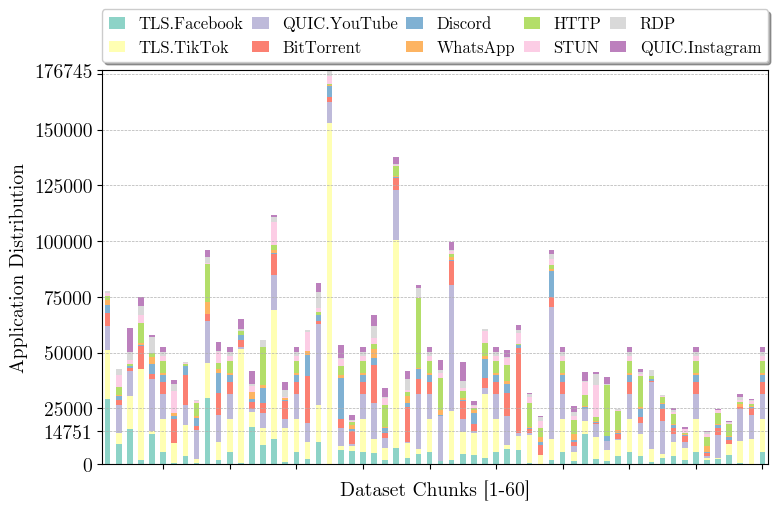

In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted

# Set the font family and size
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = 14

# Set the Seaborn color palette
sns.set_palette('Set3')

# Label mapping
mapping = {0: 'TLS.TikTok',
 1: 'QUIC.YouTube',
 2: 'BitTorrent',
 3: 'TLS.Facebook',
 4: 'HTTP',
 5: 'Discord',
 6: 'STUN',
 7: 'QUIC.Instagram',
 8: 'RDP',
 9: 'WhatsApp'}

# Specify the subfolder
subfolder = 'datasets/non_iid_B'

# Get all CSV files in the subfolder
csv_files = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.endswith('.csv')]

# Sort the files alphabetically
csv_files = natsorted(csv_files)

# Initialize an empty DataFrame to hold all the value counts
all_counts = pd.DataFrame()

# Initialize a variable to hold the minimum value count
min_value_count = None

# Initialize a variable to hold the maximum value count
max_value_count = 0

for idx, file in enumerate(csv_files):
# for idx, file in enumerate(csv_files[5::6]):
    # Load the CSV data
    df = pd.read_csv(file, low_memory=False)

    # Check if 'application_name' is in dataframe columns
    if 'application_name' in df.columns:
        # Replace encoded values with their respective application names
        df['application_name'].replace(mapping, inplace=True)

        # Get value counts for 'application_name'
        app_counts = df['application_name'].value_counts()
        
        total_count = app_counts.sum()
    
        # Update the minimum value count if necessary
        if min_value_count is None or total_count < min_value_count:
            min_value_count = total_count
        
        # Update the maximum value count if necessary
        if total_count > max_value_count:
            max_value_count = total_count

        # Convert the value counts to a DataFrame and transpose it
        app_counts_df = pd.DataFrame(app_counts).T

        # Change the index to the file number
        app_counts_df.index = [idx+1]  # make index 1-based

        # Append the value counts to the all_counts DataFrame
        all_counts = pd.concat([all_counts, app_counts_df])
    else:
        print(f"'application_name' column not found in {file}")

# Create the stacked bar plot for all data
ax1 = all_counts.plot(kind='bar', stacked=True, figsize=(8, 5.33))

# # Calculate the cumulative height for each x-location (i.e., for each bar)
# cumulative_heights = all_counts.sum(axis=1).tolist()

# # Iterate over the number of bars (i.e., the number of rows in all_counts) and annotate
# for i, height in enumerate(cumulative_heights):
#     x = ax1.patches[i].get_x() + ax1.patches[i].get_width() / 2
#     unique_counts = len(all_counts.iloc[i].dropna())
#     ax1.text(x, height, f'{unique_counts}', ha='center', va='bottom', fontsize=10)

# Set the y-axis ticks to include the minimum and maximum value counts
ax1.set_yticks(list(filter(lambda x: x <= max_value_count, ax1.get_yticks())) + [min_value_count, max_value_count])

# Sort the y-ticks
ax1.yaxis.set_major_locator(plt.FixedLocator(sorted(ax1.get_yticks())))

# Set the y-axis limit slightly above the maximum value count
ax1.set_ylim([0, max_value_count])

# Remove the text for the zero label on the y axis
# yticks = ax1.get_yticks()
# if 50000 in yticks:
#     yticklabels = [str(int(tick)) if tick != 50000 else '' for tick in yticks]
#     ax1.set_yticklabels(yticklabels)

# yticks = ax1.get_yticks()
# yticklabels = []
# for tick in yticks:
#     if tick not in [10000, 40000]:
#         yticklabels.append(str(int(tick)))
#     else:
#         yticklabels.append('')  # Empty string for the ticks you want to remove
# ax1.set_yticklabels(yticklabels)

# Set the legend title and place it above the plot
ax1.legend(
    #title='Application Type'
           bbox_to_anchor=(0., 1.02, 1., .102)
          , loc='lower left'
          , ncol=5
          , mode="expand"
          , borderaxespad=0.
          , fancybox=True
          , shadow=True
          , prop={'size': 12}
          , handlelength=1  # Adjust this value to reduce or increase the bar width
          )

# Set the x and y axis titles
ax1.set_xlabel('Dataset Chunks [1-60]')
ax1.set_ylabel('Application Distribution')

# Remove x-axis ticks and labels
ax1.set_xticks([5,11,17,23,29,35,41,47,53,59])
ax1.set_xticklabels([])

# Remove the text for the zero label on the y axis
yticks = ax1.get_yticks()
if 175000 in yticks:
    yticklabels = [str(int(tick)) if tick != 175000 else '' for tick in yticks]
    ax1.set_yticklabels(yticklabels)

# Customize the grid lines
ax1.grid(axis='y', linestyle='--', linewidth=0.5)

# Set plot layout to be compact
plt.tight_layout()

# Save the plot
plt.savefig('datasets/non_iid_B/non_iid_B_distribution.png', dpi=300)

plt.show()

#### Redistribute chunks between folders destined for FL clients and the server

In [21]:
import shutil
import os

# Constants
ORIGINAL_CHUNK_DIR = "datasets/non_iid_B"
DISTRIBUTION_SUBDIRS = [
    "c1_data_chunks",
    "c2_data_chunks",
    "c3_data_chunks",
    "c4_data_chunks",
    "c5_data_chunks",
    "validation_data_chunks"
]

# Ensure distribution directories exist
for subdir_name in DISTRIBUTION_SUBDIRS:
    os.makedirs(os.path.join(ORIGINAL_CHUNK_DIR, subdir_name), exist_ok=True)

# Distribute the chunks
num_chunks = 60

# Counters for each subfolder
subfolder_counters = [0] * len(DISTRIBUTION_SUBDIRS)

for i in range(1, num_chunks + 1):
    source_file = os.path.join(ORIGINAL_CHUNK_DIR, f"non_iid_chunk_{i}.csv")
    
    # Determine the target directory based on the chunk index
    target_subdir_index = (i - 1) % len(DISTRIBUTION_SUBDIRS)
    target_subdir = DISTRIBUTION_SUBDIRS[target_subdir_index]
    
    # Increment the appropriate counter and construct the target file name
    subfolder_counters[target_subdir_index] += 1
    new_chunk_name = f"non_iid_B_chunk_{subfolder_counters[target_subdir_index]}.csv"
    target_file = os.path.join(ORIGINAL_CHUNK_DIR, target_subdir, new_chunk_name)
    
    # Move the chunk to the target directory
    shutil.move(source_file, target_file)

### Prepare Non-IID-C chunks

The non-IID-C scenario is characterized by different application counts across chunks, varying application distribution and sample sizes. This represents a common real-world challenge where the number of samples per application may be incosistent, while the overall composition of the data can vary significantly.

In [22]:
import pandas as pd
import logging
from sklearn.utils import shuffle
import argparse
import numpy as np
import random
import os

# np.random.seed(42)  # set a seed for numpy
# random.seed(42)  # set a seed for python built-in random

def setup_logging(log_filename):
    os.makedirs(os.path.dirname(log_filename), exist_ok=True)
    
    with open(log_filename, 'w'):
        pass
    logging.basicConfig(level=logging.INFO,
                        format='%(message)s',
                        force=True,
                        handlers=[logging.FileHandler(log_filename),
                                  logging.StreamHandler()])

def chunk_dataframe(df, num_chunks):
    available_apps = df['application_name'].unique().tolist()

    chunks = []
    ideal_chunk_size = len(df) // num_chunks
    min_samples_per_chunk = round(ideal_chunk_size * 0.7)  # 30% less
    max_samples_per_chunk = round(ideal_chunk_size * 1.3)  # 30% more

    # Get the overall distribution of the 'application_name' in the input CSV
    app_distribution = df['application_name'].value_counts(normalize=True)

    uniform_chunks_indexes = range(6, num_chunks+1, 6) # 6th, 12th, 18th, ... chunks

    # Create uniformly distributed chunks first
    for i in uniform_chunks_indexes:
        chunk = pd.DataFrame()
        for app in available_apps:
            app_df = df[df['application_name'] == app]
            samples_to_add = int(app_distribution[app] * ideal_chunk_size)
            samples_to_add = min(samples_to_add, len(app_df))
            sample_df = app_df.sample(n=samples_to_add, replace=False, random_state=RANDOM_STATE)
            df = df.drop(sample_df.index)
            chunk = pd.concat([chunk, sample_df])
        chunks.append((i, chunk))

    total_remaining_samples = len(df)
    num_units = 50 # 60 - 10 (the uniformly distributed chunks)
#     non_iid_chunks_sizes = []
    # Initial random assignment
    non_iid_chunks_sizes = [random.randint(min_samples_per_chunk, max_samples_per_chunk) for _ in range(num_units)]

    # Calculate the difference and distribute it evenly
    difference = total_remaining_samples - sum(non_iid_chunks_sizes)
    per_chunk_difference = difference // num_units
    non_iid_chunks_sizes = [size + per_chunk_difference for size in non_iid_chunks_sizes]

    # Distribute any remaining difference to random chunks
    remaining_difference = difference % num_units
    for i in np.random.choice(num_units, remaining_difference, replace=False):
        non_iid_chunks_sizes[i] += 1

    # print(non_iid_chunks_sizes)
    # print(sum(non_iid_chunks_sizes))

    non_iid_chunk_index = 0
    for i in range(1, num_chunks + 1):
        if i in uniform_chunks_indexes:  # If it's a uniformly distributed chunk, skip
            continue

        chunk_size = non_iid_chunks_sizes[non_iid_chunk_index]
        non_iid_chunk_index += 1

        chunk = df.sample(n=chunk_size, replace=False)
        df = df.drop(chunk.index)
        chunks.append((i, chunk))

    # Sort chunks based on their index
    chunks.sort(key=lambda x: x[0])

    # Return only chunk data
    chunks = [chunk for index, chunk in chunks]

    return chunks


def redistribute_categories(chunks, app_cats_to_keep):
    num_chunks = len(chunks)
    uniform_chunks_indexes = set(range(5, num_chunks, 6))  # Indices 5, 11, 17, ... 59 (0-indexed)
    
    for i, chunk in enumerate(chunks):
        if i in uniform_chunks_indexes:
            continue  # Skip every sixth chunk
        
        available_apps = chunk['application_name'].unique().tolist()
        if not available_apps:  # If the chunk is empty, skip to the next chunk
            continue
        
        # Randomly select categories to redistribute from the current chunk
        num_categories_to_redistribute = len(available_apps) - random.randint(app_cats_to_keep, len(available_apps))
        categories_to_redistribute = random.sample(available_apps, num_categories_to_redistribute)
      
        for category in categories_to_redistribute:
            category_samples = chunk[chunk['application_name'] == category]
            # Remove category samples from the current chunk
            chunk.drop(category_samples.index, inplace=True)
            
            # Create a list of all eligible destination chunk indices
            eligible_dest_chunk_indices = list(set(range(num_chunks)) - uniform_chunks_indexes - {i})

            # Randomly select a destination chunk from the eligible indices
            dest_chunk_idx = random.choice(eligible_dest_chunk_indices)
         
            # Add category samples to the destination chunk
            chunks[dest_chunk_idx] = pd.concat([chunks[dest_chunk_idx], category_samples])

    return chunks


def filter_uniform_chunks(chunks):
    for i in range(5, len(chunks), 6):  # 5, 11, 17, ... (0-indexed) corresponds to 6, 12, 18, ... (1-indexed)
        preceding_chunks = pd.concat(chunks[i-5:i])  # Concatenate preceding 5 chunks
        preceding_categories = set(preceding_chunks['application_name'].unique())
        current_chunk = chunks[i]
        valid_rows = current_chunk['application_name'].isin(preceding_categories)
        chunks[i] = current_chunk[valid_rows]
    return chunks

def save_and_log_chunk(chunk, i, output_dir):
    logging.info(f"Distribution for Chunk {i}:\n{chunk['application_name'].value_counts().to_string(header=False)}")
    logging.info(f"Percentage Distribution for Chunk {i}:\n{(chunk['application_name'].value_counts(normalize=True)* 100).round(2).to_string(header=False)}")
    logging.info(f"Total samples in Chunk {i}: {len(chunk)}")
    logging.info(f"Total count of unique application types in Chunk {i}: {chunk['application_name'].nunique()}")
    logging.info(f"-----------------")
    chunk.to_csv(os.path.join(output_dir, f'non_iid_chunk_{i}.csv'), index=False)


def non_iid_chunker(input_csv, num_chunks, app_cats_to_keep, shuffle_data, output_dir):
    setup_logging(LOG_FILENAME)
    
    try:
        df = pd.read_parquet(input_csv)
        num_chunks = int(num_chunks)
        os.makedirs(output_dir, exist_ok=True)
        
        if shuffle_data:
            df = shuffle(df, random_state=RANDOM_STATE)
        
        chunks = chunk_dataframe(df, num_chunks)
        chunks = redistribute_categories(chunks, app_cats_to_keep)
        chunks = filter_uniform_chunks(chunks)

        # Print the distribution for each chunk and save the chunks
        for i, chunk in enumerate(chunks, start=1):
            save_and_log_chunk(chunk, i, output_dir)
    
    except Exception as e:
        logging.error(f"An error occurred: {str(e)}")
        

if __name__ == "__main__":    
    # Constants
    LOG_FILENAME = "datasets/non_iid_C/non-IID-info.log"
    INPUT_CSV = 'datasets/dataset_cl.parquet'
    NUM_CHUNKS = 60
    SHUFFLE_DATA = False
    OUTPUT_DIR = "datasets/non_iid_C"
    RANDOM_STATE = 42 # with some numbers, some val chunks might have less than 10 apps!
    APP_CATS_TO_KEEP = 1

    np.random.seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)

    non_iid_chunker(INPUT_CSV, NUM_CHUNKS, APP_CATS_TO_KEEP, SHUFFLE_DATA, OUTPUT_DIR)

Distribution for Chunk 1:
0    17325
1    12090
3    10398
9     6930
2     6384
5     5699
4     3985
7     2462
Percentage Distribution for Chunk 1:
0    26.54
1    18.52
3    15.93
9    10.62
2     9.78
5     8.73
4     6.11
7     3.77
Total samples in Chunk 1: 65273
Total count of unique application types in Chunk 1: 8
-----------------
Distribution for Chunk 2:
8    5831
3    4354
Percentage Distribution for Chunk 2:
8    57.25
3    42.75
Total samples in Chunk 2: 10185
Total count of unique application types in Chunk 2: 2
-----------------
Distribution for Chunk 3:
0    36903
2    29485
1    20810
3     4043
5     2116
6     1900
9      937
Percentage Distribution for Chunk 3:
0    38.36
2    30.65
1    21.63
3     4.20
5     2.20
6     1.98
9     0.97
Total samples in Chunk 3: 96194
Total count of unique application types in Chunk 3: 7
-----------------
Distribution for Chunk 4:
0    18161
6    12726
2    11215
3     6384
7     2291
5     2069
8     1336
Percentage Distribution 

#### Plot application distribution in non-IID-C chunks

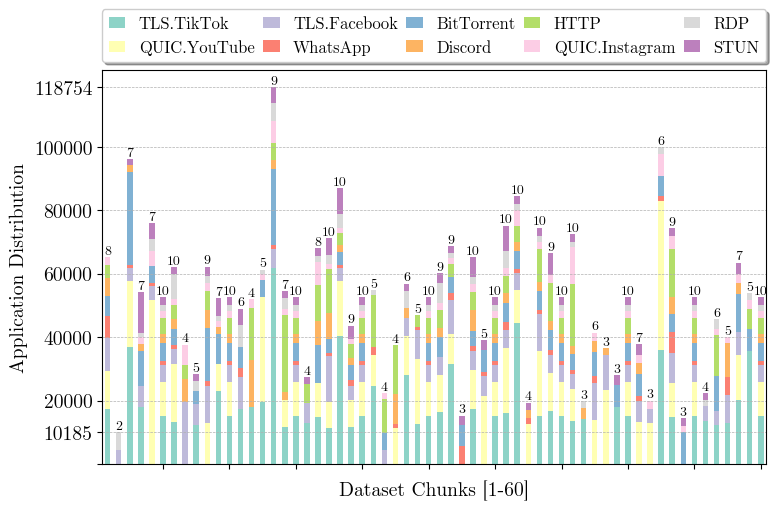

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted

# Set the font family and size
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['font.size'] = 14

# Set the Seaborn color palette
sns.set_palette('Set3')

# Label mapping
mapping = {0: 'TLS.TikTok',
 1: 'QUIC.YouTube',
 2: 'BitTorrent',
 3: 'TLS.Facebook',
 4: 'HTTP',
 5: 'Discord',
 6: 'STUN',
 7: 'QUIC.Instagram',
 8: 'RDP',
 9: 'WhatsApp'}

# Specify the subfolder
subfolder = 'datasets/non_iid_C'

# Get all CSV files in the subfolder
csv_files = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.endswith('.csv')]

# Sort the files alphabetically
csv_files = natsorted(csv_files)

# Initialize an empty DataFrame to hold all the value counts
all_counts = pd.DataFrame()

# Initialize a variable to hold the minimum value count
min_value_count = None

# Initialize a variable to hold the maximum value count
max_value_count = 0

for idx, file in enumerate(csv_files):
# for idx, file in enumerate(csv_files[5::6]):
    # Load the CSV data
    df = pd.read_csv(file, low_memory=False)

    # Check if 'application_name' is in dataframe columns
    if 'application_name' in df.columns:
        # Replace encoded values with their respective application names
        df['application_name'].replace(mapping, inplace=True)

        # Get value counts for 'application_name'
        app_counts = df['application_name'].value_counts()
        
        total_count = app_counts.sum()
    
        # Update the minimum value count if necessary
        if min_value_count is None or total_count < min_value_count:
            min_value_count = total_count
        
        # Update the maximum value count if necessary
        if total_count > max_value_count:
            max_value_count = total_count

        # Convert the value counts to a DataFrame and transpose it
        app_counts_df = pd.DataFrame(app_counts).T

        # Change the index to the file number
        app_counts_df.index = [idx+1]  # make index 1-based

        # Append the value counts to the all_counts DataFrame
        all_counts = pd.concat([all_counts, app_counts_df])
    else:
        print(f"'application_name' column not found in {file}")

# Create the stacked bar plot for all data
ax1 = all_counts.plot(kind='bar', stacked=True, figsize=(8, 5.33))

# Calculate the cumulative height for each x-location (i.e., for each bar)
cumulative_heights = all_counts.sum(axis=1).tolist()

# Iterate over the number of bars (i.e., the number of rows in all_counts) and annotate
for i, height in enumerate(cumulative_heights):
    x = ax1.patches[i].get_x() + ax1.patches[i].get_width() / 2
    unique_counts = len(all_counts.iloc[i].dropna())
    ax1.text(x, height, f'{unique_counts}', ha='center', va='bottom', fontsize=10)

# Set the y-axis ticks to include the minimum and maximum value counts
ax1.set_yticks(list(filter(lambda x: x <= max_value_count, ax1.get_yticks())) + [min_value_count, max_value_count])

# Sort the y-ticks
ax1.yaxis.set_major_locator(plt.FixedLocator(sorted(ax1.get_yticks())))

# Set the y-axis limit slightly above the maximum value count
ax1.set_ylim([0, max_value_count+5500])

# Remove the text for the zero label on the y axis
yticks = ax1.get_yticks()
if 0 in yticks:
    yticklabels = [str(int(tick)) if tick != 0 else '' for tick in yticks]
    ax1.set_yticklabels(yticklabels)

# yticks = ax1.get_yticks()
# yticklabels = []
# for tick in yticks:
#     if tick not in [10000, 40000]:
#         yticklabels.append(str(int(tick)))
#     else:
#         yticklabels.append('')  # Empty string for the ticks you want to remove
# ax1.set_yticklabels(yticklabels)

# Set the legend title and place it above the plot
ax1.legend(
    #title='Application Type'
           bbox_to_anchor=(0., 1.02, 1., .102)
          , loc='lower left'
          , ncol=5
          , mode="expand"
          , borderaxespad=0.
          , fancybox=True
          , shadow=True
          , prop={'size': 12}
          , handlelength=1  # Adjust this value to reduce or increase the bar width
          )

# Set the x and y axis titles
ax1.set_xlabel('Dataset Chunks [1-60]')
ax1.set_ylabel('Application Distribution')

# Remove x-axis ticks and labels
ax1.set_xticks([5,11,17,23,29,35,41,47,53,59])
ax1.set_xticklabels([])

# Customize the grid lines
ax1.grid(axis='y', linestyle='--', linewidth=0.5)

# Set plot layout to be compact
plt.tight_layout()

# Save the plot
plt.savefig('datasets/non_iid_C/non_iid_C_distribution.png', dpi=300)

plt.show()

#### Redistribute chunks between folders destined for FL clients and the server

In [24]:
import shutil
import os

# Constants
ORIGINAL_CHUNK_DIR = "datasets/non_iid_C"
DISTRIBUTION_SUBDIRS = [
    "c1_data_chunks",
    "c2_data_chunks",
    "c3_data_chunks",
    "c4_data_chunks",
    "c5_data_chunks",
    "validation_data_chunks"
]

# Ensure distribution directories exist
for subdir_name in DISTRIBUTION_SUBDIRS:
    os.makedirs(os.path.join(ORIGINAL_CHUNK_DIR, subdir_name), exist_ok=True)

# Distribute the chunks
num_chunks = 60

# Counters for each subfolder
subfolder_counters = [0] * len(DISTRIBUTION_SUBDIRS)

for i in range(1, num_chunks + 1):
    source_file = os.path.join(ORIGINAL_CHUNK_DIR, f"non_iid_chunk_{i}.csv")
    
    # Determine the target directory based on the chunk index
    target_subdir_index = (i - 1) % len(DISTRIBUTION_SUBDIRS)
    target_subdir = DISTRIBUTION_SUBDIRS[target_subdir_index]
    
    # Increment the appropriate counter and construct the target file name
    subfolder_counters[target_subdir_index] += 1
    new_chunk_name = f"non_iid_C_chunk_{subfolder_counters[target_subdir_index]}.csv"
    target_file = os.path.join(ORIGINAL_CHUNK_DIR, target_subdir, new_chunk_name)
    
    # Move the chunk to the target directory
    shutil.move(source_file, target_file)